In [1]:
import json
from collections import defaultdict
from enum import Enum

import dateutil.parser
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np


def load(path: str):
    fh = open(path)
    data = json.load(fh)
    fh.close()
    return data


data = load("../data/merged-log-SOFTENG206-2022.json")

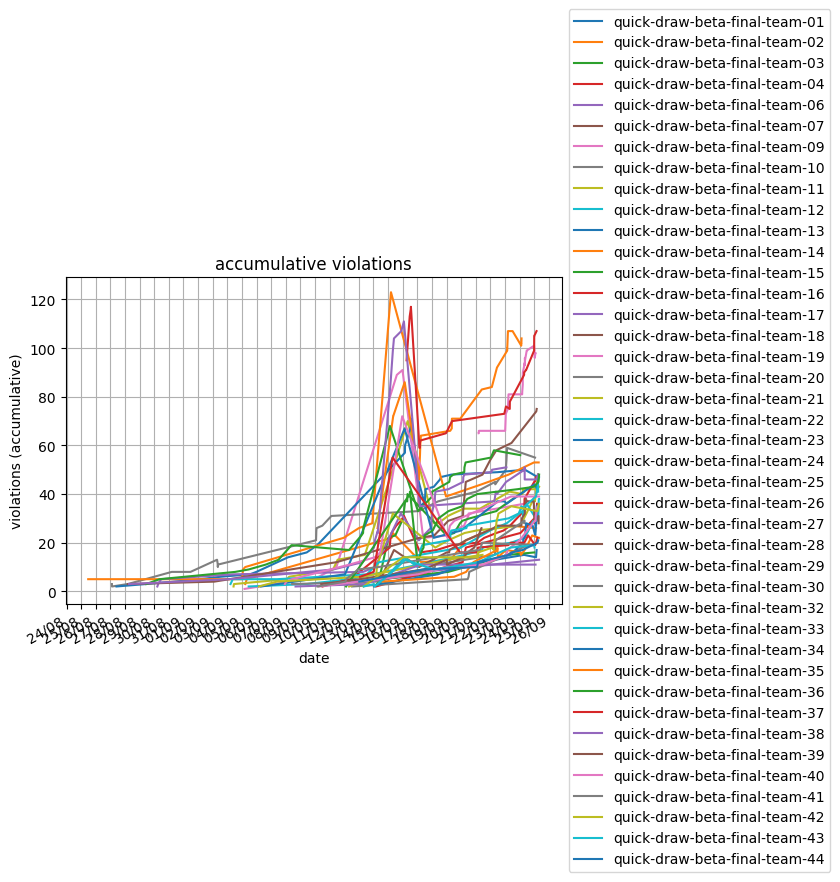

In [2]:
plt.title("accumulative violations")
plt.xlabel("date")
plt.ylabel("violations (accumulative)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()
plt.grid(True)

# accumulative violations (all violations per workflow run)
def accumulative(data):
    ds = defaultdict(list)  # date
    vs = defaultdict(list)  # violations

    for x in data:
        date = dateutil.parser.isoparse(x["date"])
        # time field only became available later but is more accurate
        if "Time" in x:
            ds[x["name"]].append(x["Time"])
        else:
            ds[x["name"]].append(date)
        vs[x["name"]].append(len(x["violations"]))

    for k in ds.keys():
        plt.plot(ds[k], vs[k], label=k)

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))


accumulative(data)

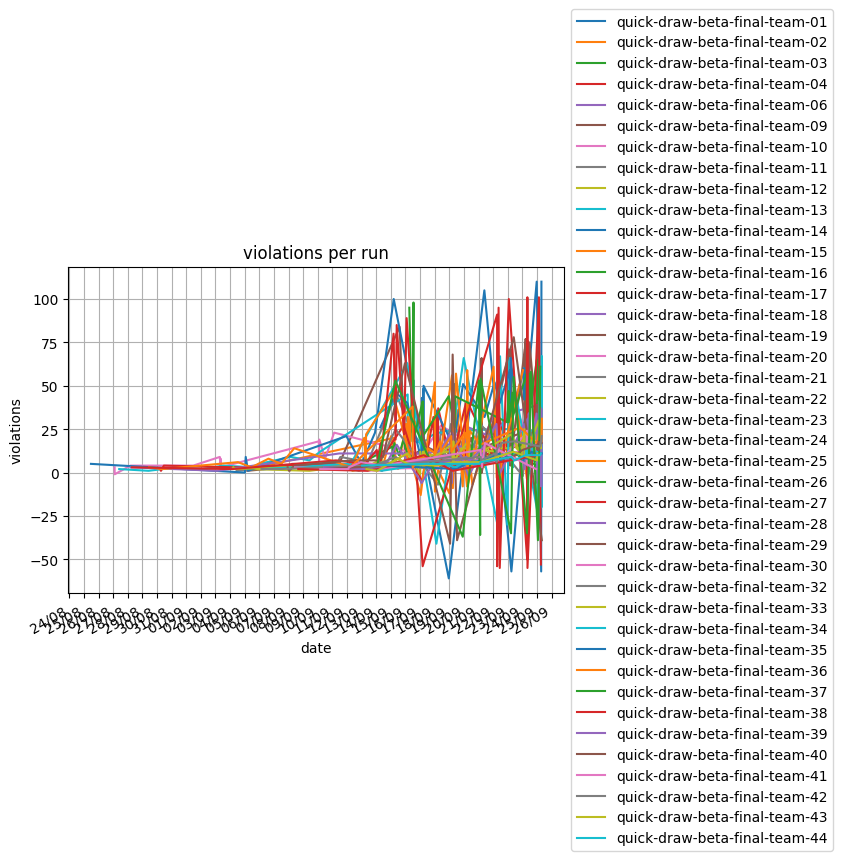

In [3]:
plt.title("violations per run")
plt.xlabel("date")
plt.ylabel("violations")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()
plt.grid(True)

# logs are "accumulative" violations (ie: all violations that exist within the project.
# instead plot as "new" violations per GHA run
def violationsPerRun(data):
    ds = defaultdict(list)  # date
    vs = defaultdict(list)  # violations

    for x in data:
        date = dateutil.parser.isoparse(x["date"])
        # time field only became available later but is more accurate
        if "Time" in x:
            ds[x["name"]].append(x["Time"])
        else:
            ds[x["name"]].append(date)
        vs[x["name"]].append(len(x["violations"]))

    for k in ds.keys():
        violations = vs[k]
        if len(violations) == 1:
            continue
        for i in range(1, len(violations)):
            violations[i] -= violations[i - 1]
        vs[k] = violations
        plt.plot(ds[k], vs[k], label=k)

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))


violationsPerRun(data)

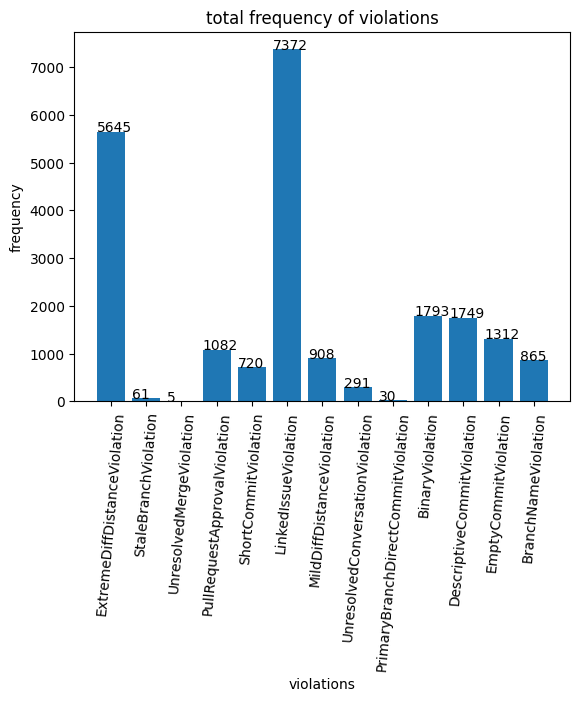

In [4]:
plt.title("total frequency of violations")
plt.xlabel("violations")
plt.ylabel("frequency")
plt.xticks(rotation=85)


def bar(data):
    violations = []
    for x in data:
        for v in x["violations"]:
            violations.append(v["Name"])
    xs = list(set(violations))
    ys = []
    for x in xs:
        ys.append(len(list(filter(lambda ys: ys == x, violations))))

    bars = plt.bar(xs, ys)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x(), yval + 0.005, yval)


bar(data)